In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class Advect1D:
    
    def __init__(self, dx, dt, scheme='lax_wendroff', limiter=None):
        self.dx = dx
        self.dt = dt
        self.flux = {
            'first_order_upwind' : self.flux_fou,
            'lax_friedrichs' : self.flux_lax_friedrichs,
            'lax_wendroff' : self.flux_lax_wendroff,
        }[scheme]
        self.limiter = {
            None : (lambda x : 1), # no limiting
            'van_leer' : self.limiter_van_leer,
            'superbee' : self.limiter_superbee,
            }[limiter]


    @staticmethod
    def diffl(u):
        d = np.zeros_like(u)
        d[1:] = np.diff(u)
        return d
    
        
    @staticmethod
    def diffr(u):
        d = np.zeros_like(u)
        d[:-1] = np.diff(u)
        return d


    @staticmethod
    def suml(u):
        s = np.zeros_like(u)
        s[0] = 2*u[0]
        s[1:] = u[1:] + u[:-1]
        return s
    
        
    @staticmethod
    def sumr(u):
        s = np.zeros_like(u)
        s[:-1] = u[:-1] + u[1:]
        s[-1] = 2*u[-1]
        return s

    
    @staticmethod
    def min(u, v):
        """
        min function that works for vectors as well as floats
        
        Parameters:
        -----------
        u : float or numpy.ndarray
        v : float or numpy.ndarray
        
        Returns:
        --------
        min_uv : float or numpy.ndarray
        """
        return .5*(u+v - np.abs(u-v))


    @staticmethod
    def max(u, v):
        """
        max function that works for vectors as well as floats
        
        Parameters:
        -----------
        u : float or numpy.ndarray
        v : float or numpy.ndarray
        
        Returns:
        --------
        max_uv : float or numpy.ndarray
        """
        return .5*(u+v + np.abs(u-v))


    def flux_fou(self, u, c):
        """
        flux for first order upwind
        
        Parameters:
        -----------
        u : numpy.ndarray
            quantity to be advected
        c : float or numpy.ndarray
            velocity
        
        Returns:
        --------
        flux : numpy.ndarray
        """
        return c*u


    def flux_lax_friedrichs(self, u, c):
        """
        flux for Lax-Friedrichs - central diference, 1st order
        
        Parameters:
        -----------
        u : numpy.ndarray
            quantity to be advected
        c : float or numpy.ndarray
            velocity
        
        Returns:
        --------
        flux : numpy.ndarray
        """
        r = self.dx/self.dt
        return .5*(c*self.sumr(u)-r*self.diffr(u))


    def flux_lax_wendroff(self, u, c):
        """
        flux for Lax-Wendroff - direct space-time, 2nd order
        
        Parameters:
        -----------
        u : numpy.ndarray
            quantity to be advected
        c : float or numpy.ndarray
            velocity
        
        Returns:
        --------
        flux : numpy.ndarray
        """
        cfl = c * self.dt / self.dx
        return .5*c*( self.sumr(u) - cfl*self.diffr(u) )


    @staticmethod
    def limiter_van_leer(theta):
        """
        van Leer flux limiter
        
        Parameters:
        -----------
        theta : numpy.ndarray
        
        Returns:
        --------
        phi : numpy.ndarray
            weighting for high-order flux
            - 1 means use high-order flux, 0 means use first-order upwind
        """
        return (theta + np.abs(theta))/(1 + np.abs(theta))
    
 
    def limiter_superbee(self, theta):
        """
        Superbee flux limiter
        
        Parameters:
        -----------
        theta : numpy.ndarray
        
        Returns:
        --------
        phi : numpy.ndarray
            weighting for high-order flux
            - 1 means use high-order flux, 0 means use first-order upwind
        """
        return self.max(0, self.max(
            self.min(1, 2*theta), self.min(theta, 2)
            ))


    def limited_flux(self, u, c):
        """
        Return limited flux to prevent oscillations from high-order flux.
        The limiting can be deactivated by instantiating object with limiter=None
        (then self.limiter=1 so only the high-order flux is used).
        
        Parameters:
        -----------
        u : numpy.ndarray
            quantity to be advected
        c : float or numpy.ndarray
            velocity
        
        Returns:
        --------
        flux : numpy.ndarray
        """
        theta = self.diffl(u)/(self.diffr(u)+3.e-14)
        phi = self.limiter(theta)
        return c*u + phi*(self.flux(u, c) - c*u)
 

    def advect(self, u, c):
        """
        Advect u for one time step.
        
        Parameters:
        -----------
        u : numpy.ndarray
            quantity to be advected
        c : float or numpy.ndarray
            velocity
        
        Returns:
        --------
        u_new : numpy.ndarray
            updated quantity
        """
        f  = self.limited_flux(u, c)
        return u - self.dt*self.diffl(f)/self.dx

## First-order upwind
Let $\mathcal{C}=c\Delta t/\Delta x$.
\begin{align}
u^{n+1}_i = u^{n}_i
- \mathcal{C}
\left(u^{n}_{i} - u^{n}_{i-1}\right).
\end{align}

## Lax-Wendroff
Let $\mathcal{C}=c\Delta t/\Delta x$.
\begin{align}
u^{n+1}_i = u^{n}_i
- \frac{\mathcal{C}}{2}
\left(u^{n}_{i+1} - u^{n}_{i-1}\right)
+\frac{\mathcal{C}^2}{2}
\left(u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1}\right)
+
\end{align}

In [3]:
def init_shape(x):
    std = 4
    return np.exp(-pow((x-15)/std, 2)/2)

In [4]:
def run(adv, u0, c, x, outdir):
    print(f'Saving figs in {outdir}')
    u = np.copy(u0)
    for n in range(50):
        plt.close()
        u = adv.advect(u, c)
        plot_step(x, u, c, n+1,  adv.dt, outdir)

In [5]:
def plot_step(x, u, c, n, dt, outdir):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, u, '--')
    t = n * dt
    exact = init_shape(x - c * t)
    ax.plot(x, exact, 'r')
    ax.set_title(f't = {t}s')
    ax.set_xlabel('x, m')
    ax.set_ylabel('c')
    figname = '%s/adv%2.2i.png' %(outdir, n)
#     print(f'Saving {figname}')
    fig.savefig(figname)

In [6]:
cfl = .9
dx = 1
dt = 1
c = .9*dx/dt
x = np.arange(100)*dx
u0 = init_shape(x)

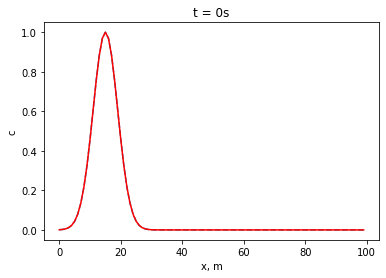

In [7]:
adv = Advect1D(dx, dt, scheme='first_order_upwind')
outdir = 'figs_fou'
os.makedirs(outdir, exist_ok=True)
plot_step(x, u0, c, 0,  dt, outdir)

Saving figs in figs_fou


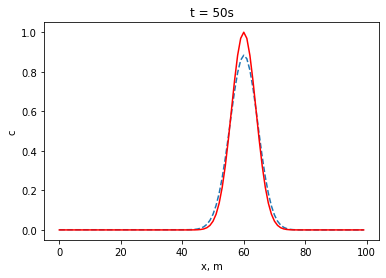

In [8]:
run(adv, u0, c, x, outdir)

Saving figs in figs_lf


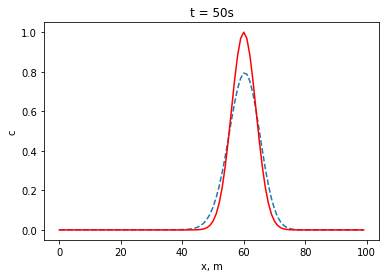

In [9]:
adv = Advect1D(dx, dt, scheme='lax_friedrichs')
outdir = 'figs_lf'
os.makedirs(outdir, exist_ok=True)
# plot_step(x, u0, c, 0,  dt, outdir)
run(adv, u0, c, x, outdir)

Saving figs in figs_lw


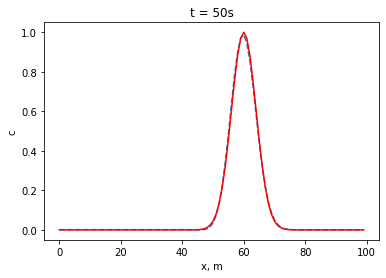

In [10]:
adv = Advect1D(dx, dt, scheme='lax_wendroff')
outdir = 'figs_lw'
os.makedirs(outdir, exist_ok=True)
# plot_step(x, u0, c, 0,  dt, outdir)
run(adv, u0, c, x, outdir)

Saving figs in figs_lw_vl


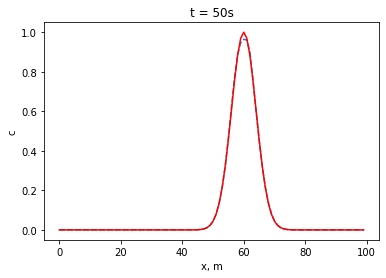

In [11]:
adv = Advect1D(dx, dt, scheme='lax_wendroff', limiter='van_leer')
outdir = 'figs_lw_vl'
os.makedirs(outdir, exist_ok=True)
# plot_step(x, u0, c, 0,  dt, outdir)
run(adv, u0, c, x, outdir)

Saving figs in figs_lw_sb


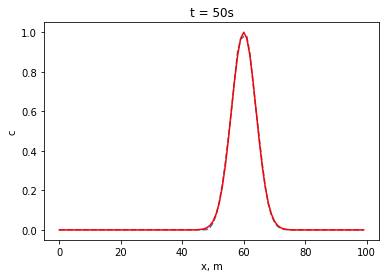

In [12]:
adv = Advect1D(dx, dt, scheme='lax_wendroff', limiter='superbee')
outdir = 'figs_lw_sb'
os.makedirs(outdir, exist_ok=True)
# plot_step(x, u0, c, 0,  dt, outdir)
run(adv, u0, c, x, outdir)